<a href="https://colab.research.google.com/github/samitf/Machine-Learning/blob/main/BikeShareDemand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Problem Statement:**

We want to predict how many bikes people will rent at a specific time using details like weather, season, and time. This helps in planning and making sure enough bikes are available when needed.

# **Problem Definition:**

The goal is to build a predictive model that estimates the total number of bikes rented at a given hour or day. The model will use input features such as:

*   Time-based features: hour, day, month, weekday, year
*   Environmental features: temperature, humidity, windspeed, weather situation
*   Calendar features: season, holiday, working day

This is a regression problem where the target variable is the continuous value cnt, which represents the total number of bikes rented (both casual and registered users). The model should learn patterns in the historical data to make accurate predictions for future rental demand.

In this project, We develop a machine learning model to predict daily bike rentals for a city bike-sharing program. This information can be used for optimizing bike distribution, staffing, and overall program efficiency.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
PATH = "/content"

In [3]:
df_raw = pd.read_csv(f'{PATH}/hour.csv')
print(df_raw.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


<Axes: xlabel='dteday'>

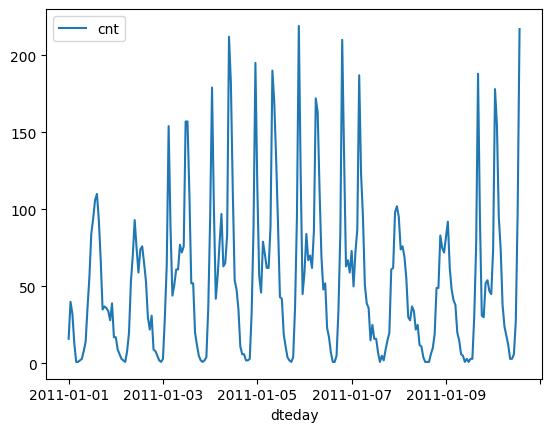

In [4]:
#first 10 days data and bikes rented
df_raw[:24*10].plot(x='dteday', y='cnt')

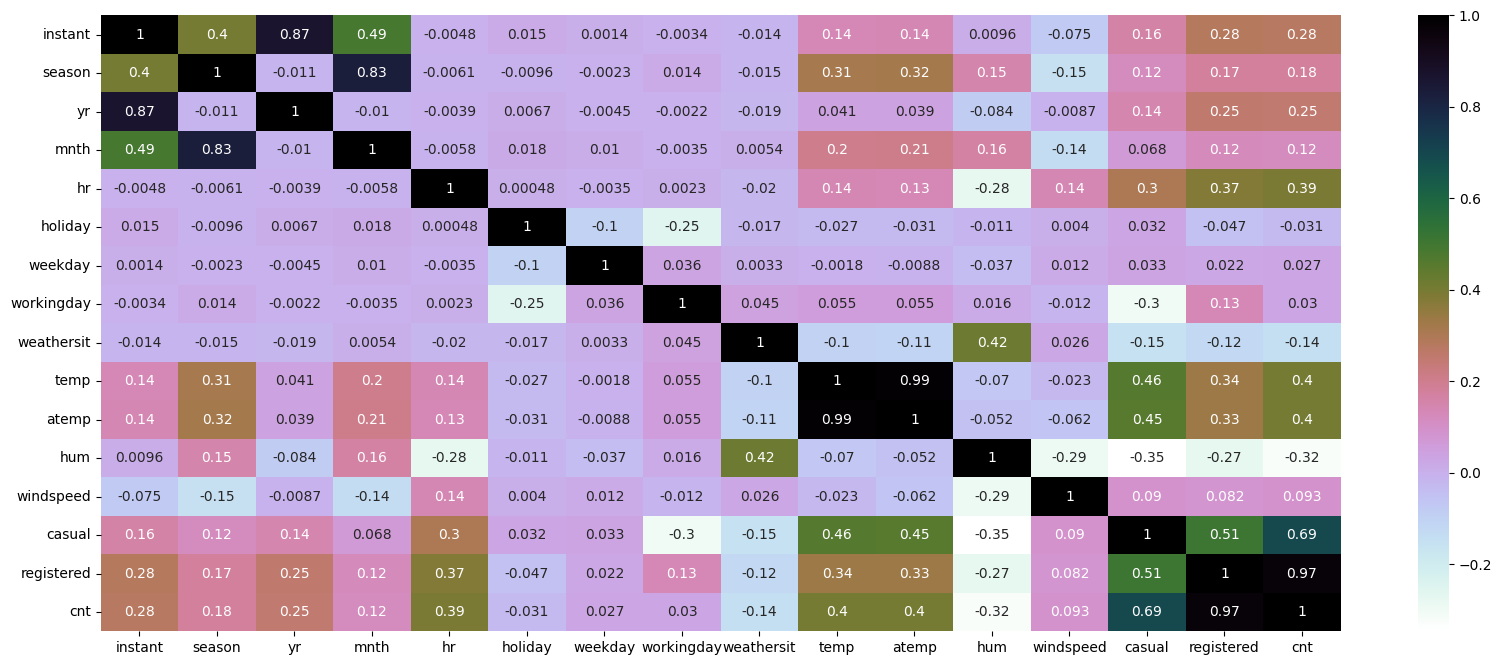

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter df_raw to include only numeric columns
numeric_df_raw = df_raw.select_dtypes(include='number')

# Calculate the correlation matrix of the filtered data frame
correlation_matrix = numeric_df_raw.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r')
plt.show()

In [6]:
# Printing the unique values stored by data
col_list = list(df_raw.columns.values)
for i in col_list:
    print(i)
    # print(eval("df_raw." + i + ".unique()"))

instant
dteday
season
yr
mnth
hr
holiday
weekday
workingday
weathersit
temp
atemp
hum
windspeed
casual
registered
cnt


## Data Preprocessing

In [8]:
# Presence of null values
df_raw= df_raw.fillna(np.nan)
total = df_raw.isnull().sum().sort_values(ascending=False)

percent = (df_raw.isnull().sum()/df_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(5))

         Total  Percent
instant      0      0.0
dteday       0      0.0
season       0      0.0
yr           0      0.0
mnth         0      0.0


In [9]:
#Catagorical Variables to one hot encoding
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(df_raw[each], prefix=each, drop_first=False)
    df_raw = pd.concat([df_raw, dummies], axis=1)

print(df_raw.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0           1  ...  False  False  False      False      False      False   
1           1  ...  False  False  False      False      False      False   
2           1  ...  False  False  False      False      False      False   
3           1  ...  False  False  False      False      False      False   
4           1  ...  False  False  False      False      False      False   

   weekday_3  weekday_4  weekday_5  weekday_6  
0      False      False   

In [10]:
print(df_raw.dtypes)

instant       int64
dteday       object
season        int64
yr            int64
mnth          int64
              ...  
weekday_2      bool
weekday_3      bool
weekday_4      bool
weekday_5      bool
weekday_6      bool
Length: 68, dtype: object


In [17]:
# dropping 'season', 'weathersit', 'mnth', 'hr', 'weekday'
# as we have created corresponding catagorical variables

# instant as it is like id, 'atemp' as correlation exists between temp and atemp
# 'workingday' as weekday encompasses all the information of it basically (1 or 0)

# 'dteday' because we have feature columns for mnth, hr, day
fields_to_drop = ['instant', 'season', 'weathersit', 'atemp', 'workingday',
                  'weekday', 'mnth', 'hr', 'dteday']
# df_raw = df_raw.drop(fields_to_drop, axis=1)
print(df_raw.head())

   yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16      True   
1   0        0  0.22  0.80        0.0       8          32   40      True   
2   0        0  0.22  0.80        0.0       5          27   32      True   
3   0        0  0.24  0.75        0.0       3          10   13      True   
4   0        0  0.24  0.75        0.0       0           1    1      True   

   season_2  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0     False  ...  False  False  False      False      False      False   
1     False  ...  False  False  False      False      False      False   
2     False  ...  False  False  False      False      False      False   
3     False  ...  False  False  False      False      False      False   
4     False  ...  False  False  False      False      False      False   

   weekday_3  weekday_4  weekday_5  weekday_6  
0      False      False      False       True  
1 

To make training the network easier, we'll standardize each of the continuous variables.

In [18]:
# Scaling continous features
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_raw[each].mean(), df_raw[each].std()
    scaled_features[each] = [mean, std]
    df_raw.loc[:, each] = (df_raw[each] - mean)/std

/tmp/ipython-input-18-510077962.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.662736   -0.56132647 -0.62217218 ... -0.58160837 -0.45991693
 -0.48019884]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_raw.loc[:, each] = (df_raw[each] - mean)/std
/tmp/ipython-input-18-510077962.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93016249 -0.80463169 -0.83766611 ... -0.46768062 -0.69892155
 -0.77159727]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_raw.loc[:, each] = (df_raw[each] - mean)/std
/tmp/ipython-input-18-510077962.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.95631172 -0.82399838 -0.86810283 ... -0.54834558 -0.7082242
 -0.77438087]' has dtype incompati

## Splitting data to train, test and validation set

In [19]:
# Save data for approximately the last 21 days
test_data = df_raw[-21*24:]
# Now remove the test data from the data set
df_raw = df_raw[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = df_raw.drop(target_fields, axis=1), df_raw[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained.

In [20]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [21]:
print(train_features.shape)
print(train_targets.shape)
print(len(val_features))
print(len(test_data))

(15435, 56)
(15435, 3)
1440
504


In [22]:
# since we have 3 target column we choose total ie 'cnt' (count)
print(train_targets['cnt'].head())

0   -0.956312
1   -0.823998
2   -0.868103
3   -0.972851
4   -1.039008
Name: cnt, dtype: float64


In [23]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Model Building

Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

parameters = {'max_depth':[30, 35, 40, 45]}
regr = RandomForestRegressor(random_state=0, n_estimators=200).fit(train_features, train_targets['cnt'])
clf = GridSearchCV(regr, parameters, cv=5, n_jobs=-1)

In [25]:
regr.score(train_features,train_targets['cnt'])

0.9897501290710423

In [26]:
val_y = regr.predict(val_features)
r2_score(val_targets['cnt'], val_y)

0.8216209299778401

Mean Squared Error (MSE): 2292.193261488421
R-squared (R2): 0.9276120800348046


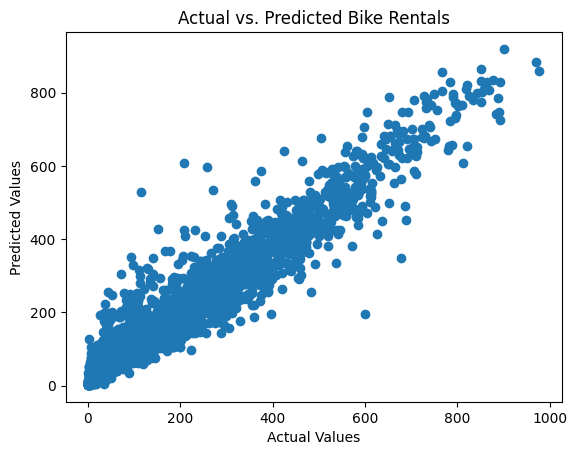

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv('/content/hour.csv')

# Drop irrelevant columns
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

# Convert categorical columns to dummy variables (one-hot encoding)
df = pd.get_dummies(df, columns=['season', 'mnth', 'hr', 'weekday', 'weathersit'])

# Split the data into features and target
X = df.drop('cnt', axis=1).values
y = df['cnt'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Bike Rentals')
plt.show()

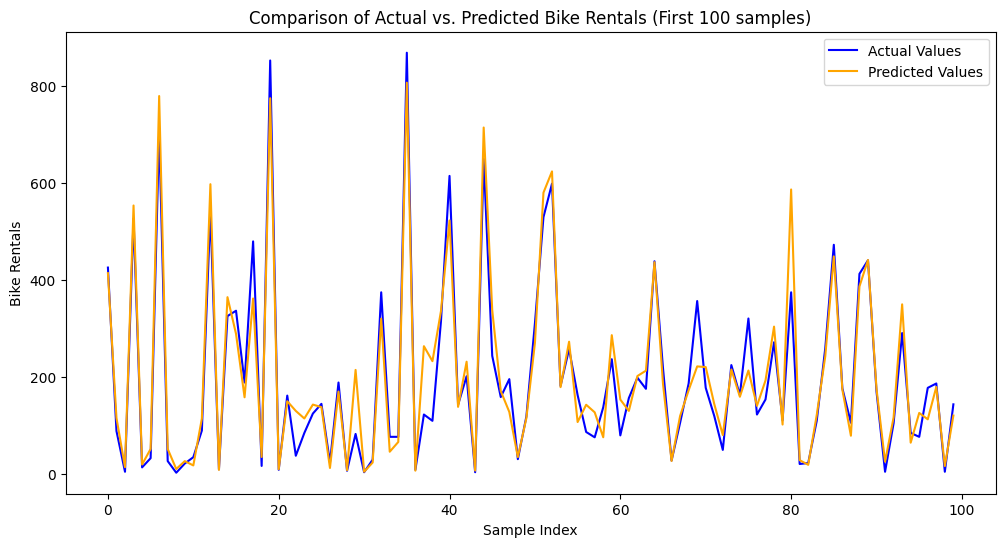

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Predicted Values', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.title('Comparison of Actual vs. Predicted Bike Rentals (First 100 samples)')
plt.legend()
plt.show()